In [1]:
# import block
import cv2
import numpy as np
from pathlib import Path
import os
import csv

# Homography matrix (2 images)

In [4]:
 
# Open the image files.
img1_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch0.png")  # Image to be aligned.
img2_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch5.png")     # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
height, width = img2.shape
  
# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(5000)
  
# Find keypoints and descriptors.
# The first arg is the image, second arg is the mask
#  (which is not required in this case).
kp1, d1 = orb_detector.detectAndCompute(img1, None)
kp2, d2 = orb_detector.detectAndCompute(img2, None)
  
# Match features between the two images.
# We create a Brute Force matcher with 
# Hamming distance as measurement mode.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
  
# Match the two sets of descriptors.
matches = list(matcher.match(d1, d2))
  
# Sort matches on the basis of their Hamming distance.
matches.sort(key = lambda x: x.distance)
  
# Take the top 90 % matches forward.
matches = matches[:int(len(matches)*0.9)]
no_of_matches = len(matches)
  
# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))
  
for i in range(len(matches)):
  p1[i, :] = kp1[matches[i].queryIdx].pt
  p2[i, :] = kp2[matches[i].trainIdx].pt
  
# Find the homography matrix.
homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
  
%%time
# Use this matrix to transform the
# colored image wrt the reference image.
transformed_img = cv2.warpPerspective(img1_color,
                    homography, (width, height))
  
# Save the output.
cv2.imwrite('output.png', transformed_img)

True

## All images in the folder (homography)

In [13]:

def retrieve_images(root_dir=Path('/mnt/buf/PSI/Multispec/Code/Registration(Medium)/FIRE/Images'), template_img=0):

    # Get the list of image filenames (I left only those, which apparently represented same eye)
    image_filenames = [f for f in os.listdir(root_dir)]
    
    # Read the images into a list
    images = [cv2.imread(str(root_dir / f)) for f in image_filenames]
    # Convert the images to grayscale
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    # Register all images to the first image
    template = gray_images[template_img]

    height, width = template.shape
    
    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(5000)
    
    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kt, dt = orb_detector.detectAndCompute(template, None)
    homography_arr = []
    for num, image in enumerate(gray_images):
        k2, d2 = orb_detector.detectAndCompute(image, None)
    
        # Match features between the two images.
        # We create a Brute Force matcher with 
        # Hamming distance as measurement mode.
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
        
        # Match the two sets of descriptors.
        matches = list(matcher.match(dt, d2))
        
        # Sort matches on the basis of their Hamming distance.
        matches.sort(key = lambda x: x.distance)
        
        # Take the top 90 % matches forward.
        matches = matches[:int(len(matches)*0.9)]
        no_of_matches = len(matches)
        
        # Define empty matrices of shape no_of_matches * 2.
        pt = np.zeros((no_of_matches, 2))
        p2 = np.zeros((no_of_matches, 2))
        
        for i in range(len(matches)):
            pt[i, :] = kt[matches[i].queryIdx].pt
            p2[i, :] = k2[matches[i].trainIdx].pt
        
        # Find the homography matrix.
        homography, mask = cv2.findHomography(p2, pt, cv2.RANSAC)
        homography_arr.append(homography)
        # Use this matrix to transform the
        # colored image wrt the reference image.
        transformed_img = cv2.warpPerspective(images[num],
                            homography, (width, height))
        
        # Save the output.
        cv2.imwrite(f'output_channel{num}.png', transformed_img)
    # now we save homography_arr as csv file

    b = open('homography_matrices.csv', 'w')
    a = csv.writer(b)
    a.writerows(homography_arr)
    b.close()
    b
    return homography_arr
        
                
            



## Homography matrix decomposition (so far failing)

In [9]:
def decompose_homography(H):
    # Extract rotation and translation
    R = H[:2, :2]
    t = H[:2, 2]
    
    # Calculate rotation angle in degrees
    theta = np.arctan2(R[1, 0], R[0, 0]) * 180 / np.pi
    
    # Calculate pixel shift in x and y directions
    shift_x = t[0]
    shift_y = t[1]
    # Calculate scaling factor
    s = np.linalg.norm(R[:, 0]) + np.linalg.norm(R[:, 1]) / 2
    
    
    return shift_x, shift_y, theta, s

In [14]:
%%time
hom_arr = retrieve_images(template_img=4)
for num, arr in enumerate(hom_arr):
    # Example usage
    shift_x, shift_y, theta, s = decompose_homography(arr)
    print(f"--------------Channel {num}---------------")
    print(f"Pixel shift in x of channel {num} is: {round(shift_x,2)}")
    print(f"Pixel shift in y of channel {num} is: {round(shift_y, 2)}")
    print(f"Rotation in channel {num} is {round(theta, 2)} degrees: ")
    print(f" ")
    


--------------Channel 0---------------
Pixel shift in x of channel 0 is: 2.26
Pixel shift in y of channel 0 is: 1.81
Rotation in channel 0 is 0.03 degrees: 
 
--------------Channel 1---------------
Pixel shift in x of channel 1 is: 6.21
Pixel shift in y of channel 1 is: 4.5
Rotation in channel 1 is 0.03 degrees: 
 
--------------Channel 2---------------
Pixel shift in x of channel 2 is: -0.16
Pixel shift in y of channel 2 is: -0.16
Rotation in channel 2 is 0.01 degrees: 
 
--------------Channel 3---------------
Pixel shift in x of channel 3 is: -1.99
Pixel shift in y of channel 3 is: -0.94
Rotation in channel 3 is -0.06 degrees: 
 
--------------Channel 4---------------
Pixel shift in x of channel 4 is: 0.0
Pixel shift in y of channel 4 is: 0.0
Rotation in channel 4 is 0.0 degrees: 
 
--------------Channel 5---------------
Pixel shift in x of channel 5 is: -2.31
Pixel shift in y of channel 5 is: -1.14
Rotation in channel 5 is -0.04 degrees: 
 
CPU times: user 13 s, sys: 405 ms, total: 

# Affine transformation variant
(should be a bit faster, but little bit less precise)

In [26]:
# Open the image files.
img1_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch0.png")  # Image to be aligned.
img2_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch5.png")     # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
height, width = img2.shape

# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(5000)

# Find keypoints and descriptors.
kp1, d1 = orb_detector.detectAndCompute(img1, None)
kp2, d2 = orb_detector.detectAndCompute(img2, None)

# Match features between the two images.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = list(matcher.match(d1, d2))

# Sort matches based on distance.
matches.sort(key=lambda x: x.distance)

# Take the top 90% matches.
matches = matches[:int(len(matches)*0.9)]

# Extract matched keypoints.
src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# Find affine transform.
affine, mask = cv2.estimateAffine2D(src_pts, dst_pts, method=cv2.RANSAC, ransacReprojThreshold=5)

# Apply transform to the image.
transformed_img = cv2.warpAffine(img1_color, affine, (width, height))

# Save the output.
cv2.imwrite('Affine_output.png', transformed_img)


True

# Geometric similar transformation 
### (affine with 4 DOF - translation (x; y), rotation, scaling)
**Less precise, but easy for decomposition**

In [4]:
  
# Open the image files.
img1_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch0.png")  # Image to be aligned.
img2_color = cv2.imread("/mnt/buf/PSI/Multispec/2023.04.21_alignment_photo/Original images/1st alignment_ch5.png")     # Reference image.

# Convert to grayscale.
img1 = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)
height, width = img2.shape
  
# Create ORB detector with 5000 features.
orb_detector = cv2.ORB_create(5000)
  
# Find keypoints and descriptors.
# The first arg is the image, second arg is the mask
#  (which is not required in this case).
kp1, d1 = orb_detector.detectAndCompute(img1, None)
kp2, d2 = orb_detector.detectAndCompute(img2, None)
  
# Match features between the two images.
# We create a Brute Force matcher with 
# Hamming distance as measurement mode.
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
  
# Match the two sets of descriptors.
matches = list(matcher.match(d1, d2))
  
# Sort matches on the basis of their Hamming distance.
matches.sort(key = lambda x: x.distance)
  
# Take the top 90 % matches forward.
matches = matches[:int(len(matches)*0.9)]
no_of_matches = len(matches)
  
# Define empty matrices of shape no_of_matches * 2.
p1 = np.zeros((no_of_matches, 2))
p2 = np.zeros((no_of_matches, 2))
  
for i in range(len(matches)):
  p1[i, :] = kp1[matches[i].queryIdx].pt
  p2[i, :] = kp2[matches[i].trainIdx].pt
  
# Find the affine transformation matrix.
affine_transform, mask = cv2.estimateAffinePartial2D(p1, p2, cv2.RANSAC)
  
# Use this matrix to transform the
# colored image wrt the reference image.
transformed_img = cv2.warpAffine(img1_color, affine_transform, (width, height))
  
# Save the output.
cv2.imwrite('output.png', transformed_img)
cv2.imwrite('img1_orig.png', img1)
cv2.imwrite('img2_orig.png', img2)


True

In [45]:
tn_teta = round(round(affine_transform[1,0], 6)/round(affine_transform[0,0], 6),6)
teta_degrees = round(np.arctan(tn_teta)*180/np.pi, 6)
scaling = round(affine_transform[0,0]/np.cos(teta_degrees*np.pi/180), 6)

In [44]:
print(f"Pixel shift in x is: {round(affine_transform[0,2],2)}")
print(f"Pixel shift in y is: {round(affine_transform[1,2],2)}")
print(f"Rotation is {round(teta_degrees, 4)} degrees: ")
print(f"Scale coeficient is {scaling}")

Pixel shift in x is: 13.59
Pixel shift in y is: -3.25
Rotation is 0.467 degrees: 
Scale coeficient is 0.996597


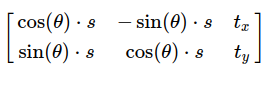

In [26]:
arctan_teta = np.arctan(tn_teta)

In [27]:
arctan_teta

-0.008150826352087